In [1]:
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from sklearn.preprocessing import StandardScaler, maxabs_scale
from keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_auc_score,f1_score, roc_curve, auc, accuracy_score, confusion_matrix
import shutil

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from model import MeronSmart, ml_models,plot_confusion_matrix

In [3]:
meron = MeronSmart()

In [4]:
dense_model = meron.build_model(reg_val=None)

In [5]:
dense_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               262528    
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                2064      
_________________________________________________________________
activation_2 (Activation)    (None, 16)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 51        
Total para

In [6]:
merged_df = pd.read_csv('/data/meron/kenya_data/meron_merged_mal(sam_mam_upsampled)_muac.csv')
meta_data = pd.read_csv('/data/meron/kenya_data/meron_link_data/meron_meta_processed.csv')
sam_names=pd.read_csv('/data/meron/sam_photo_ids.csv')
mam_names=pd.read_csv('/data/meron/mam_photo_ids.csv')

#use wfh in meta_data to filter wfh<4
merged_df=merged_df[merged_df['wfh']<4]

In [7]:
merged_df.head()

,photo_id,0,1,2,3,4,5,6,7,8,...,2046,2047,gender_male,age_months,maln_mam,maln_normal,maln_sam,wfh,maln_class,muac_prediction
0,1517384891739.jpg,0.157335,0.015997,0.707683,0.009274,0.000000,0.698504,1.974866,6.329210,0.0,...,1.867832,0.024899,0,32.0,1,0,0,-2.97,mam,normal
1,1517384891739.jpg,0.000000,0.000000,1.571181,0.000000,0.000000,0.627390,1.353355,6.647170,0.0,...,2.161191,0.000000,0,32.0,1,0,0,-2.97,mam,normal
2,1517478268776.jpg,0.045922,0.000000,3.087823,0.000000,0.331306,1.069497,1.636940,1.760356,0.0,...,4.154829,0.812403,1,19.0,1,0,0,-2.09,mam,normal
3,1517478268776.jpg,0.181375,0.000000,3.747156,0.022242,1.065049,1.856126,1.670891,2.034269,0.0,...,3.283012,1.401969,1,19.0,1,0,0,-2.09,mam,normal
4,1517238175403.jpg,0.000000,0.369026,2.461378,2.946527,0.661946,4.072535,0.526728,6.682256,0.0,...,2.062518,0.352439,1,18.0,0,1,0,-1.16,normal,normal


# separate the sam samples so duplicates(flipped image) are not distributed evenly in training and test. samples in validation set are not seen in training

In [8]:
sam_samples=merged_df.loc[merged_df['photo_id'].isin(sam_names['photo_id'])]
mam_samples=merged_df.loc[merged_df['photo_id'].isin(mam_names['photo_id'])]

other_samples=merged_df.loc[~merged_df['photo_id'].isin(sam_names['photo_id'])].loc[~merged_df['photo_id'].isin(mam_names['photo_id'])]

In [23]:
print('sam sample size:{}'.format(sam_samples.shape))
print('mam sample size:{}'.format(mam_samples.shape))
print('other sample size:{}'.format(other_samples.shape))

sam sample size:(228, 2056)
mam sample size:(944, 2056)
other sample size:(3019, 2056)


In [11]:
sam_train=sam_samples[:188]
sam_validation=sam_samples[188:]
print('sam training size:{}'.format(sam_train.shape))
print('sam val size:{}'.format(sam_validation.shape))

sam training size:(188, 2057)
sam val size:(40, 2057)


In [12]:
mam_train=mam_samples[:750]
mam_validation=mam_samples[750:]
print('mam training size:{}'.format(mam_train.shape))
print('mam val size:{}'.format(mam_validation.shape))

mam training size:(750, 2057)
mam val size:(194, 2057)


In [14]:
sam_train.head()

,photo_id,0,1,2,3,4,5,6,7,8,...,2046,2047,gender_male,age_months,maln_mam,maln_normal,maln_sam,wfh,maln_class,muac_prediction
5,1519634722743.jpg,0.000000,0.218025,0.000000,0.237022,0.013627,0.799962,1.346431,13.252592,0.000000,...,2.831110,2.128186,1,29.0,0,0,1,-4.96,sam,normal
6,1519634722743.jpg,0.000000,0.310197,0.000000,0.000000,0.538029,1.071039,2.753774,14.217513,0.000000,...,2.450462,3.501058,1,29.0,0,0,1,-4.96,sam,normal
22,1517308385587.jpg,0.000000,1.070153,0.883892,0.000000,2.273226,0.432866,0.370594,9.211809,0.108621,...,0.715576,0.080925,1,23.0,0,0,1,-3.03,sam,mam
23,1517308385587.jpg,0.000000,1.022285,3.869135,0.089626,2.712403,1.364627,0.538262,10.137850,0.012134,...,0.276103,0.006144,1,23.0,0,0,1,-3.03,sam,mam
39,1517470917615.jpg,3.025537,0.023323,2.381346,0.524410,0.000000,0.000000,5.221360,3.948538,9.314640,...,0.257508,0.000000,0,57.0,0,0,1,-3.14,sam,normal


In [13]:
target_sam_train = np.array(sam_train[['maln_mam','maln_normal','maln_sam']])
target_sam_validation=np.array(sam_validation[['maln_mam','maln_normal','maln_sam']])
target_sam_muac_validation=np.array(sam_validation['muac_prediction'])

target_mam_train = np.array(mam_train[['maln_mam','maln_normal','maln_sam']])
target_mam_validation=np.array(mam_validation[['maln_mam','maln_normal','maln_sam']])
target_mam_muac_validation=np.array(mam_validation['muac_prediction'])


target_other=np.array(other_samples[['maln_mam','maln_normal','maln_sam']])
target_other_muac_validation=np.array(other_samples['muac_prediction'])

In [35]:
target_sam_muac_validation

array(['sam', 'sam', 'normal', 'normal', 'mam', 'mam', 'mam', 'mam',
       'mam', 'mam', 'normal', 'normal', 'mam', 'mam', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'mam',
       'mam', 'normal', 'normal', 'normal', 'normal', 'mam', 'mam', 'mam',
       'mam', 'normal', 'normal'], dtype=object)

In [11]:
num_mam = merged_df['maln_mam'].sum()
num_normal = merged_df['maln_normal'].sum()
num_sam = merged_df['maln_sam'].sum()
counts = [num_mam, num_normal, num_sam]
names = ('mam', 'normal','sam')
print('proportion of normal in dataset: {}'.format(num_normal/np.sum(counts)))
print('number of sam: {}'.format(num_sam))
print('number of mam: {}'.format(num_mam))
print('number of normal: {}'.format(num_normal))

proportion of normal in dataset: 0.7146265807683131
number of sam: 232
number of mam: 964
number of normal: 2995


In [14]:
deselect_cols = ['photo_id','maln_mam','maln_normal','maln_sam','wfh','maln_class','muac_prediction']

In [15]:
select = [x for x in merged_df.columns if x not in deselect_cols]
sam_train_features = sam_train.loc[:, select]
sam_validation_features = sam_validation.loc[:, select]

mam_train_features = mam_train.loc[:, select]
mam_validation_features = mam_validation.loc[:, select]

other_features=other_samples.loc[:, select]
other_features.head()

,0,1,2,3,4,5,6,7,8,9,...,2040,2041,2042,2043,2044,2045,2046,2047,gender_male,age_months
4,0.000000,0.369026,2.461378,2.946527,0.661946,4.072535,0.526728,6.682256,0.000000,0.0,...,0.687893,0.000000,0.000000,1.743518,0.575827,0.000000,2.062518,0.352439,1,18.0
9,6.018714,0.000000,4.922188,0.250943,3.632266,0.441533,2.783796,9.161777,0.000000,0.0,...,0.000000,0.000000,0.451506,3.653616,0.734750,0.000000,0.000000,0.000000,0,25.0
10,0.302067,0.000000,0.856374,4.006856,0.000000,0.476372,4.314477,11.858264,0.000000,0.0,...,1.534502,0.000000,0.453811,16.605633,0.000000,0.845772,0.506828,0.000000,1,40.0
11,0.000000,0.296940,4.927894,0.212098,0.008911,1.134834,3.333884,2.954910,1.047672,0.0,...,1.352508,0.005078,0.010983,8.271940,0.000000,0.000000,0.876071,0.032372,0,41.0
12,0.000000,0.228124,0.801086,0.476915,1.492239,1.457904,1.052291,18.379776,0.000000,0.0,...,0.005074,0.000000,0.000000,12.780549,0.740513,0.000000,1.912864,1.549561,0,28.0


# Split data into training and testing sets, then train model

In [234]:
whole_data=pd.concat([other_features, sam_train_features, sam_validation_features,mam_train_features,mam_validation_features], axis=0)

In [235]:
### scale/standardize the features?
conv_scaler = StandardScaler().fit(whole_data)
sam_train_features_scaled = conv_scaler.transform(sam_train_features)
sam_validation_features_scaled=conv_scaler.transform(sam_validation_features)

mam_train_features_scaled = conv_scaler.transform(mam_train_features)
mam_validation_features_scaled=conv_scaler.transform(mam_validation_features)

other_features_scaled=conv_scaler.transform(other_features)

In [236]:
### Break data into training and test (stratified)
X_train1, X_test1, y_train1, y_test1 = train_test_split(other_features_scaled, target_other, test_size=0.2, 
                                                        random_state=42, stratify=target_other)

X_train=np.concatenate((X_train1,sam_train_features_scaled,mam_train_features_scaled), axis=0)
y_train=np.concatenate((y_train1,target_sam_train,target_mam_train), axis=0)

X_test=np.concatenate((X_test1,sam_validation_features_scaled,mam_validation_features_scaled), axis=0)
y_test=np.concatenate((y_test1,target_sam_validation, target_mam_validation), axis=0)

In [237]:
### fetch data with muac_prediction, only care about the target for validation
X_train2, X_test2, y_train2, y_test2 = train_test_split(other_samples, target_other, test_size=0.2, 
                                                        random_state=42, stratify=target_other)

#X_train=np.concatenate((X_train1,sam_train_features_scaled,mam_train_features_scaled), axis=0)
#y_train=np.concatenate((y_train1,target_sam_train,target_mam_train), axis=0)

#X_test=np.concatenate((X_test1,sam_validation_features_scaled,mam_validation_features_scaled), axis=0)
y_test_muac=np.concatenate((X_test2['muac_prediction'],target_sam_muac_validation, target_mam_muac_validation), axis=0)

In [58]:
print(X_train.shape)
print(X_test.shape)

(3353, 2050)
(838, 2050)


In [256]:
y_test_labeled=pd.DataFrame({'y_test':np.argmax(y_test, axis=1)})
#y_test_labeled
#print(y_test_labeled[3])
y_test_wfh=y_test_labeled['y_test'].map({0:'mam', 1:'normal', 2:'sam'})

In [257]:
y_test_comparison=pd.DataFrame({'wfh_classification':y_test_wfh,
                            'muac_classification':y_test_muac},
                           columns = ['wfh_classification','muac_classification'])

In [287]:
y_test_comparison=pd.read_csv('y_test_comparisons.csv')
y_test_ensemble_pred=pd.read_csv('y_test_ensemble_pred.csv')

In [288]:
y_test_ensemble_pred.shape

(838, 1)

In [16]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)
checkpoint = ModelCheckpoint('dense_resnetfeats_128_16(dropout05_filtered_upsampled2x).h5', monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min')

## compute class weight
w = compute_class_weight('balanced', np.unique(merged_df.maln_class), merged_df.maln_class)
w

dense_model.compile(loss='categorical_crossentropy',
                               optimizer=Adam(lr=1e-4),
                               metrics=['accuracy'])

In [20]:
dense_model.fit(X_train,
                y_train,
                epochs=1000,
                batch_size=512,
                callbacks=[checkpoint, early_stop],
                shuffle=True,
                validation_data=(X_test, y_test),
                class_weight=meron._get_class_weights(merged_df.maln_class, neural_net=True),
                #class_weight=[3,0.3,10],
                verbose=1)

Train on 3353 samples, validate on 838 samples
Epoch 1/1000
3353/3353 [==============================] - 0s 50us/step - loss: 1.1589 - acc: 0.4426 - val_loss: 1.0427 - val_acc: 0.4177

Epoch 00001: val_loss did not improve from 0.97561
Epoch 2/1000
3353/3353 [==============================] - 0s 49us/step - loss: 1.1386 - acc: 0.4384 - val_loss: 1.0431 - val_acc: 0.4189

Epoch 00002: val_loss did not improve from 0.97561
Epoch 3/1000
3353/3353 [==============================] - 0s 50us/step - loss: 1.1043 - acc: 0.4396 - val_loss: 1.0417 - val_acc: 0.4224

Epoch 00003: val_loss did not improve from 0.97561
Epoch 4/1000
3353/3353 [==============================] - 0s 48us/step - loss: 1.1165 - acc: 0.4390 - val_loss: 1.0391 - val_acc: 0.4212

Epoch 00004: val_loss did not improve from 0.97561
Epoch 5/1000
3353/3353 [==============================] - 0s 48us/step - loss: 1.0889 - acc: 0.4429 - val_loss: 1.0375 - val_acc: 0.4260

Epoch 00005: val_loss did not improve from 0.97561
Epoch 6/

3353/3353 [==============================] - 0s 47us/step - loss: 0.7488 - acc: 0.5649 - val_loss: 0.9249 - val_acc: 0.5119

Epoch 00072: val_loss did not improve from 0.92425
Epoch 73/1000
3353/3353 [==============================] - 0s 49us/step - loss: 0.7427 - acc: 0.5732 - val_loss: 0.9250 - val_acc: 0.5143

Epoch 00073: val_loss did not improve from 0.92425
Epoch 74/1000
3353/3353 [==============================] - 0s 48us/step - loss: 0.7443 - acc: 0.5676 - val_loss: 0.9236 - val_acc: 0.5107

Epoch 00074: val_loss improved from 0.92425 to 0.92356, saving model to dense_resnetfeats_128_16(dropout05_filtered_upsampled2x).h5
Epoch 75/1000
3353/3353 [==============================] - 0s 51us/step - loss: 0.7667 - acc: 0.5586 - val_loss: 0.9226 - val_acc: 0.5107

Epoch 00075: val_loss improved from 0.92356 to 0.92263, saving model to dense_resnetfeats_128_16(dropout05_filtered_upsampled2x).h5
Epoch 76/1000
3353/3353 [==============================] - 0s 50us/step - loss: 0.7396 - acc

In [26]:
prediction

array([[0.12360514, 0.62314516, 0.25324973],
       [0.1966752 , 0.71819   , 0.0851348 ],
       [0.10398412, 0.8853804 , 0.01063551],
       ...,
       [0.09733242, 0.7806217 , 0.12204589],
       [0.69188035, 0.24125844, 0.06686119],
       [0.6096208 , 0.29724312, 0.09313609]], dtype=float32)

# Confusion matrix


In [44]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        #cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [41]:
cnf_matrix=confusion_matrix(true_classes, pred_classes)

Confusion matrix, without normalization
[[104  88   6]
 [210 383   6]
 [ 15  26   0]]


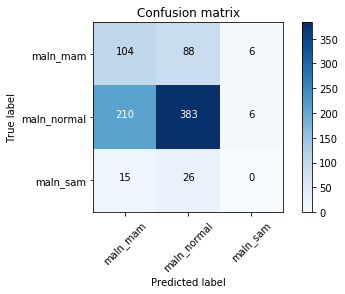

In [42]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=('maln_mam','maln_normal','maln_sam'))

# Model ensembling

In [49]:
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing

In [293]:
model_1=load_model('dense_resnetfeats_64_16(dropout05_filtered_upsampled2x).h5')
model_2=load_model('dense_resnetfeats_128_16(dropout05_filtered_upsampled2x).h5')
model_3=load_model('dense_resnetfeats_256_64_16(dropout05_filtered_upsampled2x).h5')


In [294]:
prediction_1=model_1.predict(X_test, verbose=1)
prediction_2=model_2.predict(X_test, verbose=1)
prediction_3=model_3.predict(X_test, verbose=1)

838/838 [==============================] - 0s 348us/step


In [53]:
le = preprocessing.LabelEncoder()
y_test_label_muac=le.fit_transform(y_test_muac)

In [295]:
total_pred_svm=np.concatenate((prediction_1, prediction_2,prediction_3), axis=1)
total_target_svm=y_test_label_muac

In [296]:
x_train_svm, x_test_svm, y_train_svm, y_test_svm = train_test_split(total_pred_svm, total_target_svm, test_size=0.2, 
                                                        random_state=42, stratify=total_target_svm)


In [128]:
print(x_train_svm.shape)
print(x_test_svm.shape)

(670, 9)
(168, 9)


In [290]:
## take the mean of hte predicted values
final_pred=[]
for i, prob in enumerate(total_pred_svm):
    class0_mean=np.mean((prob[0],prob[3],prob[6]))
    class1_mean=np.mean((prob[1],prob[4],prob[7]))
    class2_mean=np.mean((prob[2],prob[5],prob[8]))
    mean_pred=[class0_mean, class1_mean, class2_mean]
    final_pred.append(np.argmax(mean_pred))  
    
accuracy_score(total_target_svm, final_pred)    

0.6587112171837709

In [291]:
cnf_matrix=confusion_matrix(total_target_svm, final_pred)

Confusion matrix, without normalization
[[ 17  31   1]
 [239 535  13]
 [  2   0   0]]


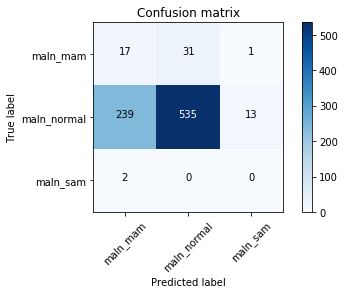

In [292]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=('maln_mam','maln_normal','maln_sam'))

# SVM fit on three models

In [151]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing

In [152]:
clf = SVC(C=1.5, kernel='rbf',random_state=18,class_weight='balanced',tol=0.0001)

In [153]:
svm_model=clf.fit(x_train_svm, y_train_svm)

In [154]:
svm_pred=svm_model.predict(x_test_svm)
accuracy_score(y_test_svm, svm_pred) #accuracy

0.5535714285714286

In [155]:
cv_score = cross_val_score(svm_model, total_pred_svm, total_target_svm, cv=5)
print(cv_score)

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[0.53254438 0.65680473 0.58083832 0.47904192 0.28915663]


Confusion matrix, without normalization
[[ 4  6  0]
 [63 89  6]
 [ 0  0  0]]


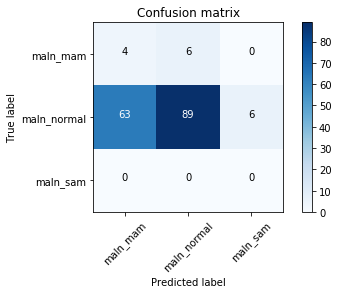

In [156]:
cnf_matrix=confusion_matrix(y_test_svm, svm_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=('maln_mam','maln_normal','maln_sam'))

# Extra tree

In [215]:
e_tree = ExtraTreesClassifier(n_estimators=10, max_depth=8,min_samples_split=2, max_features=None,
                              random_state=18,class_weight='balanced')

In [216]:
e_tree.fit(x_train_svm, y_train_svm)

ExtraTreesClassifier(bootstrap=False, class_weight='balanced',
           criterion='gini', max_depth=8, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=18,
           verbose=0, warm_start=False)

In [217]:
#for stratified validation sample
e_tree_pred=e_tree.predict(x_test_svm)

e_tree.score(x_test_svm, y_test_svm)

0.8690476190476191

In [218]:
cv_score = cross_val_score(e_tree, total_pred_svm, total_target_svm, cv=5)
print(cv_score)

[0.89349112 0.89940828 0.89221557 0.86227545 0.8373494 ]


/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


In [219]:
cnf_matrix=confusion_matrix(y_test_svm,e_tree_pred)

Confusion matrix, without normalization
[[  1   9]
 [ 13 145]]


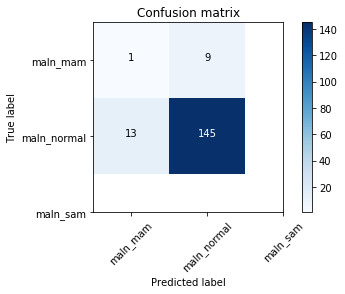

In [220]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=('maln_mam','maln_normal','maln_sam'))

# Random Forest did not perform well, it didn't catch the any of the sam class

In [221]:
rf = RandomForestClassifier(n_estimators=20, max_depth=None, min_samples_split=2, 
                            class_weight='balanced',random_state=18)

In [222]:
rf.fit(x_train_svm, y_train_svm)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=18,
            verbose=0, warm_start=False)

In [223]:
#for stratified validation sample
rf_pred=rf.predict(x_test_svm)
rf.score(x_test_svm, y_test_svm) #accuracy


0.9345238095238095

In [109]:
cv_score = cross_val_score(rf, total_pred_svm, total_target_svm, cv=5)
print(cv_score)

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[0.93491124 0.93491124 0.94011976 0.94011976 0.94578313]


Confusion matrix, without normalization
[[  0  10   0]
 [  0 157   1]
 [  0   0   0]]


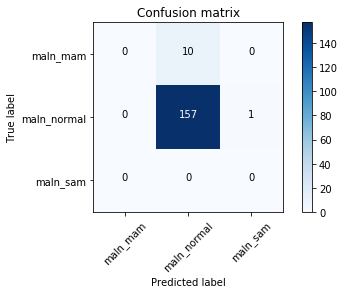

In [224]:
cnf_matrix=confusion_matrix(y_test_svm,rf_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=('maln_mam','maln_normal','maln_sam'))

In [225]:
## xgb?
import xgboost as xgb
from xgboost.sklearn import XGBClassifier


In [226]:
xgb = XGBClassifier(objective='multi:softprob', n_estimators=50, subsample=1.0, gamma=2.0,learning_rate=0.001,
                   max_depth=10,random_state=18)


In [227]:
xgb.fit(x_train_svm, y_train_svm)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=2.0, learning_rate=0.001,
       max_delta_step=0, max_depth=10, min_child_weight=1, missing=None,
       n_estimators=50, n_jobs=1, nthread=None, objective='multi:softprob',
       random_state=18, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1.0)

In [228]:
#for stratified validation sample
xgb_pred=rf.predict(x_test_svm)
xgb.score(x_test_svm, y_test_svm) #accuracy


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.9166666666666666

In [229]:
cv_score = cross_val_score(xgb, total_pred_svm, total_target_svm, cv=5)
print(cv_score)

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this w

[0.92307692 0.93491124 0.92814371 0.94011976 0.94578313]


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Confusion matrix, without normalization
[[  0  10   0]
 [  0 157   1]
 [  0   0   0]]


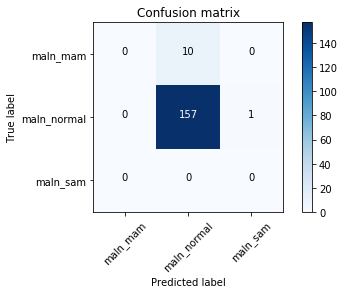

In [230]:
cnf_matrix=confusion_matrix(y_test_svm,xgb_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=('maln_mam','maln_normal','maln_sam'))